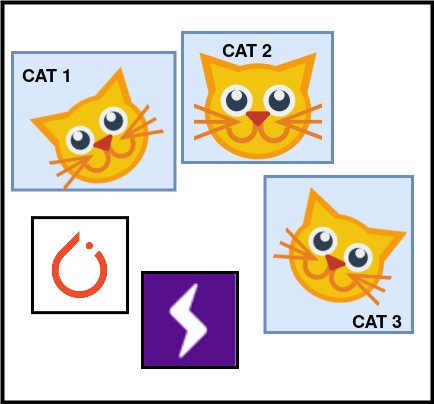

# Table of Content

Welcome to this beginner friendly guide to **object detection** using **EfficientDet**. Similarly to what I have done in the NLP guide (check it [here](https://www.kaggle.com/yassinealouini/roberta-meets-tpus) if you haven't yet already), there 
will be a mix of **theory**, **practice**, and an **application** to the [global wheat competition dataset](https://www.kaggle.com/c/global-wheat-detection). 



This will be a very long notebook, so use the following table of content if necessary. Grab something to drink and enjoy!

- [Introduction](#intro)
- [Modern Computer Vision](#modern-cv) 
 * [Different Detection Tasks](#different-tasks)
 * [Object Detection 101](#od-101)
 * [Object Detection Models Zoology](#od-zoology)
- [EfficientDet Explained](#efficientdet)
 * [EfficientNet as a Backbone](#"effnet-backbone")
 * [BiFPN as a Multi-Scale Fusion](#bifpn)
 * [Two Heads](#heads)
 * [Compound Scalings](#scalings)
- [Application: Global Wheat Detection](#application)
 * [Understanding the Task](#understanding)
 * [Evaluation Metric](#evaluation-metric)
 * [Data processing](#processing)
 * [The Model](#model)
 * [The Dataset](#dataset)
 * [Pytorch Complete Training Pipeline](#pipeline)
 * [Evaluation](#evaluation)
 * [Inference](#inference)
 
- [Advanced Concepts](#advanced)
 * [Mosaic Augmentation](#augmentation)
 * [TTA](#tta)
 * [WBF](#wbf)
 
- [To Wrap up](#wrap-up)
- [To Go Beyond](#going-beyond)


One last thing before I start, I have benefited immensely from the following two notebooks: 

- A Pytorch Lightning end-to-end training [pipeline](https://www.kaggle.com/artgor/object-detection-with-pytorch-lightning) by the great [Andrew Lukyanenko](https://www.kaggle.com/artgor). There is a Github [repo](https://github.com/Erlemar/wheat) as well if you want better organised code. If youy don't know who Andrew "artgor" is, now is the time to discover lots of cool notebooks. ;)

- A Pytorch (no Lightning this time) end-to-end training [pipeline](https://www.kaggle.com/shonenkov/training-efficientdet) by the great  [Alex Shonenkov](https://www.kaggle.com/shonenkov). Check his work, he has many other great CV notebooks.

With these shoutouts out of the way, let's start.

<a id="intro"></a>
# Introduction 

Computer vision went through a fast cycle of innovations and improvements starting in **2012** with 
the [AlexNet](https://en.wikipedia.org/wiki/AlexNet) network revolution.

Indeed, this was according to many one of the moments that launched again the field of deep learning from the last ["AI winter"](https://en.wikipedia.org/wiki/AI_winter): for the first time, it was possible to train neural networks unsing **large dataset**s and **lots of compute** (well according to 2012's standards anyway :p).

This is what made the model achive state of the art performance on [ImageNet](http://www.image-net.org/). Indeed, it has achieved in 2012 a **top-5 error of 15.3%** which was 10% better than pervious year's performance (the lower, the better). 

So, what does this network contain?

The **AlexNet** network is quite simple: different **[CNN](https://cs231n.github.io/convolutional-networks/)** layers followed by max-pooling then a fully-connected layer. 

Fast forward to 2020, a lot of things happened and the performances kept improving year after year: ImageNet is now considered a "solved" (kind of in most cases at least) dataset. In fact, it has been solved since at least **2015** with the introduction of the [**ResNet**](https://en.wikipedia.org/wiki/Residual_neural_network) model, i.e. getting performance better than human-level for the first time (see the graph below). 



<img src="https://i0.wp.com/semiengineering.com/wp-content/uploads/2019/10/Synopsys_computer-vision-processors-EV7-Fig2-ImageNet.jpeg?w=640&ssl=1">


Source: https://semiengineering.com/new-vision-technologies-for-real-world-applications/

To read more about what happened over the last years in the field of deep learning, check the following [blog post](https://adeshpande3.github.io/adeshpande3.github.io/The-Last-5-Years-in-Deep-Learning)

Most of these systems share similar architectures and modern "tips" to make them work best.

In what follows, I will detail some of what makes the modern computer vision ecosystem.

Here we go!

<a id="modern-cv"></a>
# Modern Computer Vision 

Before focusing on **object detection**, let's move one step back and explore the modern computer vision landscape. 

The first step was making CNNs work: that's roughly what happened around 2012 and has been improved ever since as discussed in the previous section. 

Then, the idea was to make the networks deeper to get better performances. Two main problems appeared then: 

1. networks got too many parameters
2. convergence wasn't fast or happening at all

To solve these issues, few interesting ideas were introduced. As stated by Karpathy in one talk (haven't found the link yet, if you know it, please share in the comments): "more zeros, better performance". What does that mean? In short, more 0s everywhere in the network: 

- Max-pooling instead of average pooling
- ReLU layer
- Dropout 

Thus less parameters.

Something else happened: **code discovery**, **sharing**, and **reproducibility** got better. I don't have 
any data to back this claim but that's what I have observed through experience. For instance, [papers with code](https://paperswithcode.com/) is probably the best place to look for a code implementation.

Also, the **code ecosystem** got much better. Among the recent code libraries and tools: 

- [Pytorch](https://pytorch.org/) and the [torchvision](https://pytorch.org/docs/stable/torchvision/index.html) library particularly for computer vision tasks
- [Pytorch Lightning](https://github.com/PyTorchLightning/pytorch-lightning) for easier training
- [Fastai](https://www.fast.ai/) and its CV module for an intrigated experience with latest CV best practices.

Finally, some of the recent research trends:

- more efficient architectures, i.e. even less parameters. More on this in the following sections.
- automated neural architecture search
- transfer learning
- application of attention ideas from the recent NLP progress. Check this blog [post](https://towardsdatascience.com/self-attention-in-computer-vision-2782727021f6) for some details.

All these things make the modern-days computer vision ecosystem. Let's now move to the subfield of **object detection**.

<a id="different-tasks"></a>

## Different Detection Tasks

We will mainly focus on **three** similar **detection tasks** (from simpler to more complex):
    
- object detection
- semantic segmentation
- instance segmentation

Object detection is the easiest one. It consists in placing bounding boxes around detected objects. The two remaining tasks are best described in the image below:

<img src="https://i.stack.imgur.com/MEB9F.png">

Source: https://datascience.stackexchange.com/questions/52015/what-is-the-difference-between-semantic-segmentation-object-detection-and-insta


All three tasks share the following thing: given an **object** the aim is to **locate** some pixels that identify it: 

- for object detection, 4 numbers are predicted (either two corners or  center and width and height, check the figure below for more details) and a label's probability. 
- for semantic segmentation, the countours of each label are predicted (more numbers), i.e. for each pixel predict to which class it belongs.
- for instance segmentation, the instances of each label are predicted (much more numnbers), i.e. for each pixel predict to which class it belongs + its id.


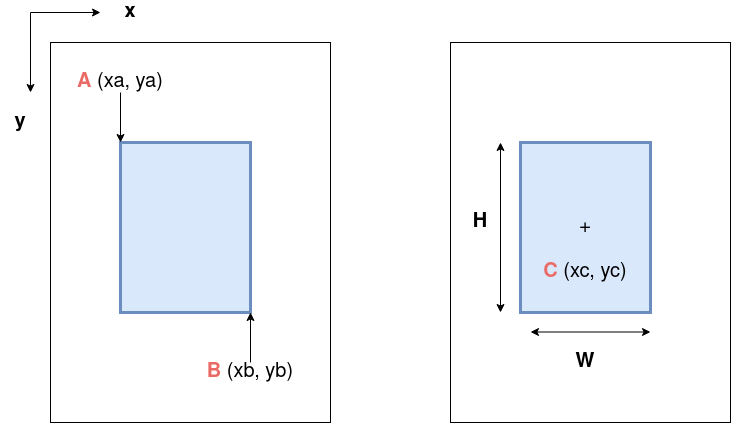


The two most popular ways to annotate a bounding box. Left for the reader: how to move from one to the other?

Now that we are more familiar with the general detection tasks, we can move to **object detection**.   

<a id="od-101"></a>

## Object Detection 101

What is object detection?

For humans, this is a straightforward question: given an **image** and a **label**, draw a **bounding box** around the detected objects. In other words, it is localization plus classification of objects.

However, translating this task into an algorithm is on another level of hard. 
Indeed, where do you even start?


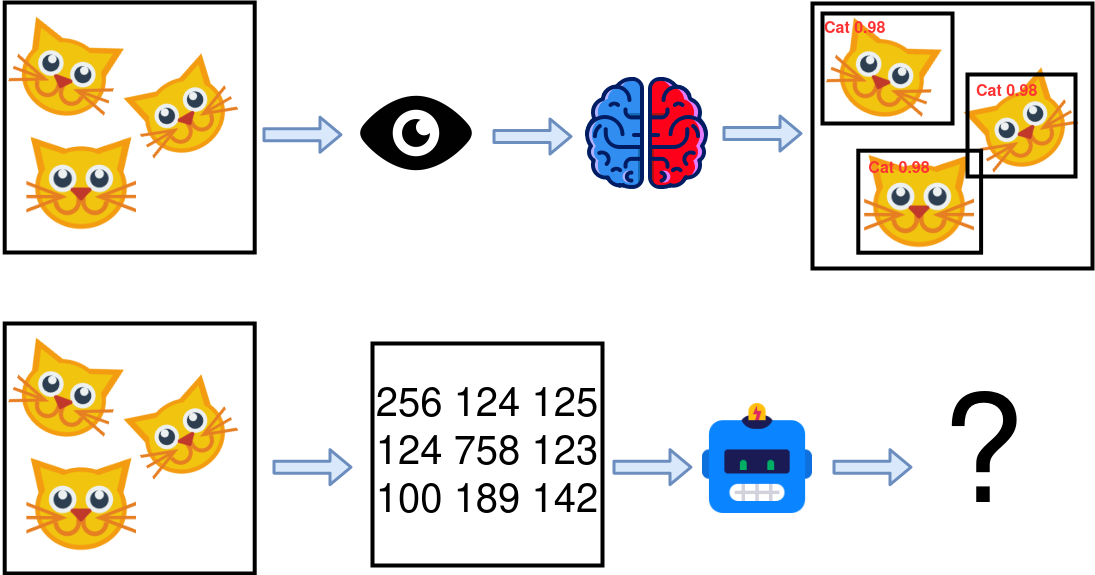


Legend: on top, human perspective. Bottom, computer perspective.


I also like this definition from [paperswithcode](https://paperswithcode.com/task/object-detection/latest): 

> Object detection is the task of detecting instances of objects of a certain class within an image. The state-of-the-art methods can be categorized into two main types: one-stage methods and two stage-methods. One-stage methods prioritize inference speed, and example models include YOLO, SSD and RetinaNet. Two-stage methods prioritize detection accuracy, and example models include Faster R-CNN, Mask R-CNN and Cascade R-CNN.
The most popular benchmark is the MSCOCO dataset. Models are typically evaluated according to a Mean Average Precision metric.



Fortunately, we don't need to really understand what goes inside our brains. It appears that 
deep learning models are very good at that. Indeed, given the latest [ImageNet](http://www.image-net.org/) and [COCO](https://cocodataset.org/#home) benchmarks, deep learning models are beating human-level performance: that was the case on the ImageNet dataset since 2015 and that's the case for the COCO dataset since . 

So, the next question is: how to design a good neural network for object detection?


Let's have a look at the most common techniques to have a feel for what works. From Wikipedia's [object detection](https://en.wikipedia.org/wiki/Object_detection) page: 
    
* Region Proposals (R-CNN,Fast R-CNN, Faster R-CNN, cascade R-CNN, and so on)
* Single Shot MultiBox Detector (SSD) 
* You Only Look Once (YOLO) 
* Single-Shot Refinement Neural Network for Object Detection (RefineDet)
* Retina-Net 
* Deformable convolutional networks

We can also add **EfficientDet** ;). Well this list isn't very informative, is it? 
Based on my own experience (basically reading a lot of blog posts and papers), there are **two** major families: 

- Two steps networks
- One step networks

R-CNN and its "cousins" fall into the first family of models. 
In contrast to the R-CNN family, SSD, YOLO, RetinaNet, CeneterNet and EfficientDet fall into the faster, one step family. 


Finally, to learn more about these two families of models, check this [blog post](https://cv-tricks.com/object-detection/faster-r-cnn-yolo-ssd/) and this [slides deck](https://fr.slideshare.net/pfi/a-brief-history-of-object-detection-tommi-kerola) telling a brief history of object detection. 

Let's explore further this rich ecosystem of models.

<a id="od-zoology"></a>

## Object Detection Models Zoology

As stated above, it seems that deep learning models, particularly convolutional ones are very good at image processing tasks, and in particular object detection. We won't explore why this is the case so feel free to explore this subject on your own. One possible explanation is that deep neural networks are good at distilling features from noisy inputs and this can be explained by the 
[information bottleneck theory](https://en.wikipedia.org/wiki/Information_bottleneck_method). 

Instead, let's explore some SOTA (state-of-the-art) models and see what they have in common: 


* **SSD**: [paper](https://arxiv.org/pdf/1512.02325.pdf) and pytorch [implementation]. (https://pytorch.org/hub/nvidia_deeplearningexamples_ssd/). Notice that SSD stands for "Single Shot MultiBox Detector".

* **FPN**: [paper](https://openaccess.thecvf.com/content_cvpr_2017/papers/Lin_Feature_Pyramid_Networks_CVPR_2017_paper.pdf) and pytorch [implementation](https://github.com/jwyang/fpn.pytorch). Notice that FPN stands for "Feature Pyramid Networks". 

* **RetinaNET**: [paper](https://arxiv.org/pdf/1708.02002.pdf) and pytorch [implementation](https://github.com/yhenon/pytorch-retinanet). 

* **Mask RCNN**: [paper](https://arxiv.org/pdf/1703.06870.pdf) and pytorch [tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) on how to fine-tune it. Notice that this model is a generalization of [Faster RCNN](https://arxiv.org/abs/1506.01497) that adds instance segmentation on top of object detection. 

* **CenterNet**: [paper](https://arxiv.org/pdf/1904.08189.pdf) and pytorch [implementation](https://github.com/xingyizhou/CenterNet).

* **YOLO**: [website](https://pjreddie.com/darknet/yolo/) and v3 [paper](https://pjreddie.com/media/files/papers/YOLOv3.pdf). As the website claims, it is 100 times faster than Mask RCNN. There is even a v5 [now](https://github.com/ultralytics/yolov5). Notice that YOLO stands for "You Only Look Once". 

* **EfficientDet**: [paper](https://arxiv.org/pdf/1911.09070.pdf) and pytorch [implementation](https://github.com/rwightman/efficientdet-pytorch). 

* **DETR**: model detection using the transformer architecture. [paper](https://arxiv.org/abs/2005.12872) and pytorch [implementation](https://github.com/facebookresearch/detr). 



To dig deeper, here are some more details:


* **SSD**

  * SSD is short for single shot detector
  * As it is clear from its name, it belonges to the one step family
  * Paper accepted around 2016 (end of)
  
  <img src="https://paperswithcode.com/media/methods/Screen_Shot_2020-06-27_at_1.59.27_PM.png" width=480>
  
  
* **FPN**

  * FPN is short for feature pyarmic network
  * This isn't an object detection network per say but rather a part
  * It is used in many architecture as the features extraction part
  * Paper accepted in 2017

* **Mask R-CNN**

  * From the region proposals series of models, this is the latest one
  * It is an extension of faster r-cnn for instance segmentation
  * It seems that it gives better results even for object detection
  * To learn more, read [this](https://medium.com/@jonathan_hui/what-do-we-learn-from-region-based-object-detectors-faster-r-cnn-r-fcn-fpn-7e354377a7c9) blog post and [this](https://paperswithcode.com/method/mask-r-cnn) paperswithcode page.


* **RetinaNet**

  * Uses focal loss
  
  <img src="https://miro.medium.com/max/558/1*FCV96tP679EScoiwKq4IaQ.png" width=240>
  
  * Uses FPN as its features extraction layer 
  
  <img src="https://miro.medium.com/max/1395/1*jQFeF7gj6uCXVzUb08S9lg.png" width=480>

* **CenterNet**

  * Paper accepted in 2019
  * Estimates the center of the bounding box in addition to the corners
  * Belongs to the one stage family of models 
  * Claims to have the best performance for the one stage family and not very far from the best in two stages as well
  * Has two networks: one for finding the center and one for finding the corners
  * As usual, to learn more check the paperswithcode [page](https://paperswithcode.com/method/centernet)
  
  <img src="https://paperswithcode.com/media/methods/Screen_Shot_2020-06-23_at_12.29.21_PM_bAPb2Mm.png" width=480>

* **YOLO**

  * Uses a different format for the outputted bounding box: the center + width and height instead of top-left and bottom-right corners. 
  * Among the one stage family of models
  * Fast predictions with great mAP
  * Latest versions use FPN as a features extracting layer
  * Has been through many iterations (latest being v4). If you want a very complete blog post, check this [one](https://medium.com/@jonathan_hui/yolov4-c9901eaa8e61) and the [paperswithcode](https://paperswithcode.com/method/yolov4) page. 
  * V4  paper accepted in 2020
  
  <img src="https://paperswithcode.com/media/methods/new_ap.jpg" width=480>



* **EfficientDet**

  * Originally developed by the google brain team using architecture search. 
  * The original accompanying code could be found [here](https://github.com/google/automl/tree/master/efficientdet) 
  * A great [notebook](https://www.kaggle.com/shonenkov/training-efficientdet/notebook) to get started training an EfficientDet model on this competition dataset. Thanks to [Alex Shonenkov](https://www.kaggle.com/shonenkov). 
  * To get the backbon weights, go to the [README](https://github.com/rwightman/efficientdet-pytorch/blob/master/README.md#models) page, models section, where you can find this table and click on the weights you want

     <img src="https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F172860%2Ff93c2555f13dbf00aa02ee5af5802b51%2Feffdet_weights.png?generation=1595103664975637&amp;alt=media" width=480>
  
  * COCO AP (average precision) vs FLOPS (number of operations per second) graph:

    <img src="https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F172860%2F694e635d898de75b2a968ceb17fd9fde%2Fcoco_ap_vs_flops.png?generation=1595096249664191&amp;alt=media" width=480>


  * SOTA according to [paperwithcode](https://paperswithcode.com/paper/efficientdet-scalable-and-efficient-object). Here is graph that shows that EfficientDet-D7x (largest model) achieves it on the COCO object detection benchmark:
  
     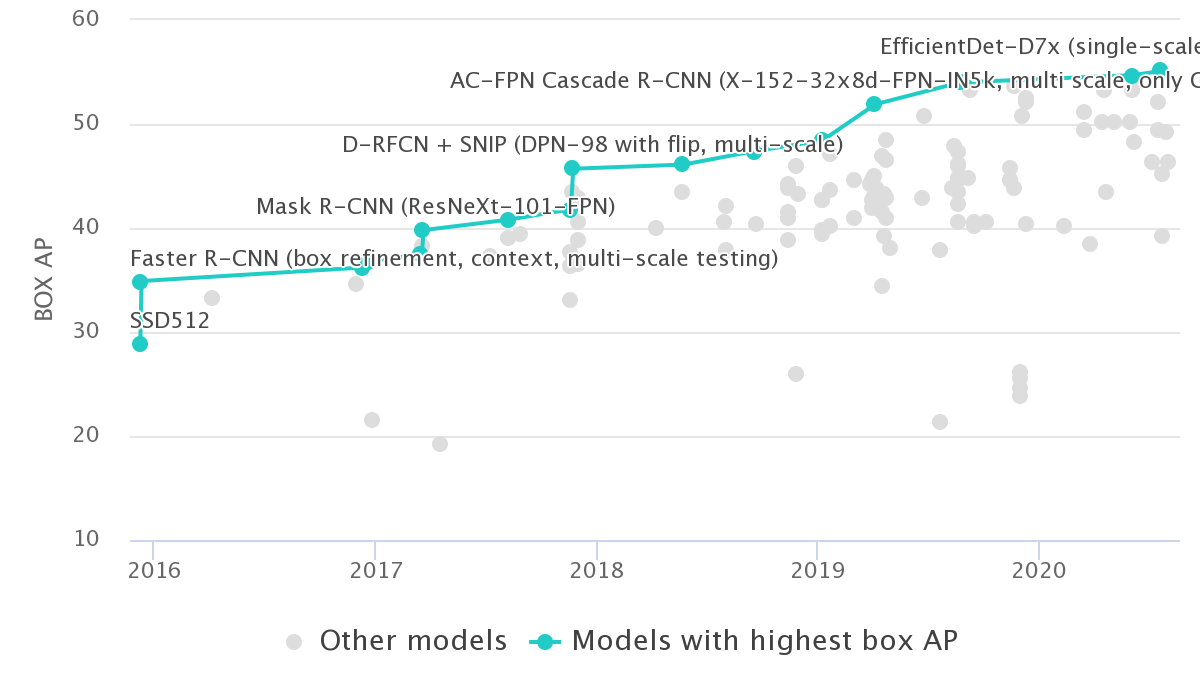
 

* **DETR** 

  * DETR is short for detection with transformer
  * Paper accepted in 2020
  * Uses a transformer layer after the feature extraction one
  * Developed by FAIR
  * To learn more, check the paperwithcodes [page](https://paperswithcode.com/method/detr)
 
  <img src="https://paperswithcode.com/media/methods/Screen_Shot_2020-07-20_at_9.17.39_PM_ZHS2kmV.png" width=480>


That was a lot of new concepts to groak, so as a reward, here is an approximate timeline: in red the one step models, and green the two steps ones. Notice that FPN doesn't have a category since it is used in both:


<img src="https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F172860%2F43b5252a12b471baa12e846bca60737d%2Fobject_detection_recent_timeline.png?generation=1600704962462342&alt=media" width=720>


That's enough general architecture for now!
In the remaining parts, we will be focusing on the **EfficienDet** family of models, more specifically on the following Pytorch [implementation](https://github.com/google/automl/tree/master/efficientdet).

<a id="efficientdet"></a>

# EfficientDet Explained

What is **EfficientDet** and how does it work?


In short, it is a recent (first submitted at the end of 2019, accepted in CVPR in 2020) very efficient (surprise surprise) object detection model.

In more details, it is a family of models designed by researchers from **Google brain**. The interesting thing is that some parts of it were designed using automatic **architecture search**, i.e. there was a meta-model that was trained to find the best hyper-parameters of the trained model automatically. Let's dive in more details.



First, let's start with the model's **architecture**: 

<img src="https://camo.githubusercontent.com/0ebd0147a2340c5ef6c3e30f2e51ab0cc812e515/68747470733a2f2f73756e392d33352e757365726170692e636f6d2f633230353632382f763230353632383732362f64323962342f67546a705534676a327a632e6a7067" width=480>


As you can see, there are **3 main** building blocks:

1. a **classification** backbone block
2. a **multi-scale features fusion** block
3. a **class** and **bounding box** networks block

In more details, we have: 

* an **EfficientNet** (**Net** and not **Det**) backbone. This backbone was found using NAS (neural-architecture search) through the use of the MnasNet framework. More on this in the next section
* **BiFPN** as a multi-scale fusion layer: once we have a classification network we need to efficiently extract features for the detection step. One extra challenge is to do so for multiple scales (learn more about this [here](https://d2l.ai/chapter_computer-vision/multiscale-object-detection.html)). These two challenges are solved efficiently using the BiFPN layer. Again, more on this in the next section.
* **Two heads**: finally, everything is connected to two output networks. One for predicting the most likely label and one for predicting the detected bounding box (if any).


To experiment with the model and learn more, check this [colab notebook](https://github.com/google/automl/blob/master/efficientdet/tutorial.ipynb), the original [paper](https://arxiv.org/pdf/1911.09070.pdf), and the original [implementation](https://github.com/google/automl/tree/master/efficientdet). 


In the following sections, we will explore each part in more details. Let's go!


<a id="effnet-backbone"></a>
## EfficientNet as a Backbone

This is the first part of the archtiecture. It uses the **EfficientNet** architecture and includes pre-trained weights.

Here is a look at the overall archtitecture:



<img src="https://miro.medium.com/max/1395/1*O1TZKZjafr9qqkxHxkJmAQ.png" width=480>

As you can see, the interesting thing is that many elements of the model have been optimized using neural automatic search: **width**, **depth**, **number of channels**, and **resolution**.

To learn more about this **EfficientNet** backbone, read the original paper [here](https://arxiv.org/pdf/1905.11946.pdf), the blog [post](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html), and the implementation [here](https://github.com/google/automl/tree/master/efficientdet/backbone) (from the **efficientdet** repo).

<a id="bifpn"></a>
## BiFPN as a Multi-Scale Fusion Layer

Once we have a classification network, one important question to ask is: how to move from the **classification** model to an **object detection** one? This is cleverly solved by using features maps (i.e. intermediate learned representations). Another question is how to detect multiple objects having different sizes (for example a small cat and a car on the same image)? This is solved by taking features maps having different sizes. 

In most modern object detection architectures, both problems are solved at once using an FPN layer. BiFPN, as its name indicates, builds upon the ideas of the FPN layer and adds one simple idea: instead of simply aggregating the different representations in a top-down fashion, it takes the PANet approach (i.e. top-down and bottom-up connections) and optimizes cross-scale connections.

One last trick is to use a weighted feature fusion instead of the unweighted FPN approach (the weights are learned as well) and normalize these weights using a fast normalization procedure (i.e. normalize by the sum instead of using softmax). Here is one example of a BiFPN computation from the paper:


<img src="https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F172860%2F612b65f04d5732669dbe04d5f0fc907d%2Fbifpn_computation_example.png?generation=1601114628541834&alt=media" width=480>


All these tricks make the BiFPN layer both efficient and accurate. We will see one additional trick applied in the next and last section. Check the following graph to learn more about other FPN variations (including PANet and BiFPN):


<img src="https://miro.medium.com/max/840/1*funGGmYqT6f2VkRnhqd2rA.png" width=480>



Finally, to learn more about FPN and BiFPN, check the papeswithcode [page](https://paperswithcode.com/method/bifpn), this [blog post](https://towardsdatascience.com/review-fpn-feature-pyramid-network-object-detection-262fc7482610), and this [one](https://medium.com/@jonathan_hui/understanding-feature-pyramid-networks-for-object-detection-fpn-45b227b9106c) as well. 

Let's move to the next step: the prediction networks.

<a id="heads"></a>

## Two Heads

The third ingredient to the mix is the **two heads network**:

- one for predicting the coordinates of the **bounding box**
- one for predicting the **class** (the probability of each class to be more precise)

Each of the two networks take as input all the ouptuts of the previous **BiFPN layer**. Then we have two fully-connected layers before getting the final values. As simple as that!

We close this section with the last trick: compound scaling.

<a id="scalings"></a>

## Compound Scaling


One last ingredient to the mix is how the network is scaled. Indeed, this is a trick often used to improve the performance 
of networks. The most common way to do it is to scale the backbone's width and depth. 

In the EfficientDet model, the EffincientNet backbone is scaled reusing the same values in the original network.
The interesting additional thing is the scaling of the BiFPN and prediction networks.
In fact, instead of using only one BiFPN and one prediction networks, these components are repeated. Finally, width ($W$), depth ($D$), and input resolution ($R$) in the different sections are scaled usign one single parammeter $\phi$ in this fashion:



- 1. $W_{bifpn} = 64 . (1.35^{\phi})$ and $D_{bifpn} = 3 + \phi$ for the **BiFPN** part
- 2. $W_{pred} = W_{bifpn}$ and $D_{bifpn} = 3 + \phi$ for the prediction part
- 3. $R_{input} = 512 + \phi . 128$ for the input image resolution. Notice that it should be divisible by 128 since we take features from levels 3 to 7 ($128 = 2 ^{7}$).


Here is the table for the different **EfficientDet** variants: the bigger $\phi$ is, the bigger the model:
    
<img src="https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F172860%2F4b349ddd45bddd490ae3bc5079cc0e25%2Fefficientdet_scalings.png?generation=1601122425468830&alt=media" width=480>


To finish this section, notice that the $1.35$ value in the first equation has been optimized using grid search (i.e. different values are tested and the one giving the best score is selected) over ${1.2, 1.25, 1.3, 1.35, 1.4, 1.45}$ values.


That's it for the model's architecture. Time to move to the application!

<a id="application"></a>
# Application to Global Wheat Challenge

<img src="https://storage.googleapis.com/kaggle-media/competitions/UofS-Wheat/descriptionimage.png">


Now that the theory makes (hopefully) more sense, let's move to the application side of things.
In the above figure, you can see a patch of wheat heads.

That's the competition's banner and that's what we are predicting: finding the bounding boxes of wheat heads.

As stated in the introduction, we will be using the **EfficientDet** model introduced above. 

Here is a rough sketch of the plan:

1. Understand the dataset, the task, and the evaluation metric
2. Process the data so that it can be used with an efficientdet model
3. Train the model 
4. Predict on test images

<a id="understanding"></a>

## Understanding the Task

As you have guessed it, the task of this competition is to predict the bounding boxes of wheat heads in different images.
The images have a varying number of wheat heads, colors, orientations, and so on making the task more challenging.

To further understand the task, let's explore the wheat images and the associated bounding boxes:  

* Train images: 

    * There is a toal of **3422** unique train images. The code to get this number:
    
    ``` python 
    from pathlib import Path
    train_paths = Path("/path/to/train")
    len(list(train_paths.glob("*")))
    ``` 
    
    * There is a total of **3373** unique images with masks
    * Thus some images don't have any masks
    * There is a toal of **147793** masks
    * Thus, on average, there are **43.8** masks per image
    * The image with the most masks contains **116**. It is the image with id `35b935b6c`.
    * All the train images have the same size: 1024 x 1024. 
    * There are 3 channels: R, G, B.
    * The train images come from **7** different sources. Here is the distribution: 

    ``` python
        {'arvalis_1': 1055,
        'arvalis_2': 204,
        'arvalis_3': 559,
        'ethz_1': 747,
        'inrae_1': 176,
        'rres_1': 432,
        'usask_1': 200}
    ``` 
        
    * **3** of these sources are probably similar: *arvalis_1*, *arvalis_2*, and *arvalis_3*. Most likely, the breakdown is by the competition sponsors/organisers?
    * Bounding boxes where added using this [tool](https://github.com/jsbroks/coco-annotator).
    * You can find resized datasets [here](https://www.kaggle.com/c/global-wheat-detection/discussion/160408).
    * There are some data quality issues: masks [too big](https://www.kaggle.com/c/global-wheat-detection/discussion/159578), or [missing masks](https://www.kaggle.com/c/global-wheat-detection/discussion/163263). The organizers are working on a fix for the private test dataset (as far as I know).
    * The average bounding box area is **6843**, the smallest is only **2**, and the largest is **529788**! Here attached the two images with the largest (upper right including many smaller) and the smallest (it is the in the lower right corner, at the edge) bounding boxes: 
    <img src="https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F172860%2F51306c59989506fbc085778805afaea0%2F42e6efaaa_with_bbox.png?generation=1594240530216553&amp;alt=media" width=480>

    <img src=https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F172860%2Fb4859bccc9fe7de7d7a19385479ab34f%2Fd0912a485_with_bbox.png?generation=1594240509985483&amp;alt=media width=480>

    * The bbox area histogram with the top 1000 values truncated and the bottom 100 as well:
    ![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F172860%2F6397d02cd4ada74403ae0eaa955394ce%2Fhist_truncated.png?generation=1594242665230885&amp;alt=media)

    * For more details about the dataset creation, check this [paper](https://arxiv.org/pdf/2005.02162.pdf). It contains a lot of statistics and data acquisition methodolgy descritption, so make sure to check it. Here are some graphs from the paper:  
    <img src="https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F172860%2F063dea7e597defdd1b44fdd3bab843be%2Fwheat_dataset_table.png?generation=1593898190270563&amp;alt=media" width=480>
    <img src="https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F172860%2F518f78637d9026e7ee76380745749a93%2Foriginal_wheat_images.png?generation=1593898211077093&amp;alt=media" width=480>
    <img src="https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F172860%2F6dd629a68c99e0f840a8c446a8bc1092%2Fwheat_table_statistics.png?generation=1593898390536691&amp;alt=media" width=480>



* Test images:

    * Only **10** images have been made public. The code to get this: 
    
    ``` python 
        from pathlib import Path
        test_paths = Path("/path/to/test")
        len(list(test_paths.glob("*")))
    ```
    
    * Don't worry though, there is a "real" test dataset that runs when you submit your inference kernel.
    * The test dataset has been collected from different sources than the train. This is an important aspect of the competition for sure.
    * There are few images in the test dataset that aren't 1024 x 1024. These will be fixed in the private part as far as I know.
    * More insights about the test dataset could be found in [this](https://www.kaggle.com/c/global-wheat-detection/discussion/149770) discussion.  

* Short code snippets: 


  * Load an image and overlay the corresponding mask(s): 
    
    ``` python 
        from pathlib import Path

        img_id = "ID_OF_IMAGE"
        img_path = Path(f"/path/to/train/{img_id}.jpg")
        img = Image.open(img_path)
        draw = ImageDraw.Draw(img)
        bboxes = train_labels_df.loc[lambda df: df["image_id"] == img_id, "bbox"].tolist()
        # The box contains the upper left corner (x, y) coordinates then width and height.
        # So we need to change these to (x1, y1) and (x2, y2) where they are the upper 
        # left and lower right corners
        for bbox in bboxes:
            x, y, w, h = eval(bbox)
            transformed_bbox = [x, y, x + w, y + h]
            draw.rectangle(transformed_bbox, outline="black", width=3)
        img.save("/path/to/output/{img_id}.png")
        img
    ```
    
    <img src="https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F172860%2Fe56c560fc347f24e44a9840c3afbf61c%2Fimag_with_bbox.png?generation=1593939578542921&amp;alt=media" width=480>

   * Extracting bounding boxes coordinates, width, height, and area: 
    
    ``` python 
        import pandas as pd
        train_labels_df = pd.read_csv("path/to/train/labels.csv")

        x = []
        y = []
        w = []
        h = []
        for bbox in train_labels_df['bbox']:
            bbox = eval(bbox)
            x.append(bbox[0])
            y.append(bbox[1])
            w.append(bbox[2])
            h.append(bbox[3])

        processed_train_labels_df = train_labels_df.copy()
        processed_train_labels_df["x"] = x
        processed_train_labels_df["y"] = y
        processed_train_labels_df["w"] = w
        processed_train_labels_df["h"] = h

        processed_train_labels_df["area"] = processed_train_labels_df["w"] * processed_train_labels_df["h"]
        processed_train_labels_df["x2"] = processed_train_labels_df["x"] + processed_train_labels_df["w"]
        processed_train_labels_df["y2"] = processed_train_labels_df["y"] + processed_train_labels_df["h"]
    ```


* Metric

    * There are many components to this metric: first, we compute Jaccard/[IoU](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/) scores, then for some threshold `t`, the wheat head is a TP if the IoU is above it, finally we compute the [precision](https://en.wikipedia.org/wiki/Precision_and_recall) for this threshold. Then, average over the thresholds (given the AP) and over images (given mAP, mean average prediction).
    * Thus, there are two levels of averaging: over the thresholds and then over the images. 
    * Notice that there are some edge-cases where the precision will be 0: no mask is predicted and there is at least one, a mask is predicted but there aren't any.

* Some backbone models that work well for object detection: 

    * [YOLOv5](https://github.com/ultralytics/yolov5)
    * [Detectron2](https://github.com/facebookresearch/detectron2): this isn't a single model but rather a collection of object detection models. It contains Faster R-CNN, RetinaNet and many more. 

* Previous similar competitions:

    * [TGS Salt Identification](https://www.kaggle.com/c/tgs-salt-identification-challenge/overview). This is an object detection competition with exactly the same metric. Here is a link to the [first place](https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/69291) solution, the code [repo](https://github.com/ybabakhin/kaggle_salt_bes_phalanx), and a [paper](https://arxiv.org/pdf/1904.04445.pdf) published.
    * [Severstal: Steel Defect Detection](https://www.kaggle.com/c/severstal-steel-defect-detection/). This isn't exactly an object detection competition but rather an **semantic segmentation** one. Here is a link the [first place](https://www.kaggle.com/c/severstal-steel-defect-detection/discussion/114254) solution. 
    * [Airbus Ship Detection](https://www.kaggle.com/c/airbus-ship-detection). Another instance segmentation competition. Here is the 4th place solution. The metric here is close to the current competition but instead of AP, it uses [F2](https://www.quora.com/What-is-the-F2-score-in-machine-learning) score. 
    * [Data Science Bowl 2018](https://www.kaggle.com/c/data-science-bowl-2018/overview/evaluation). Yet another semantic segmentation competition. The evaluation metric is exactly the same. Here is the [top solution](https://www.kaggle.com/c/data-science-bowl-2018/discussion/54741). 
    
* Some interesting ideas:

    * Multi-rounds pseudo-labelling (graph below from [here](https://arxiv.org/pdf/1904.04445.pdf))
    * Train a classifier first to find images without wheat heads
    * Randomly cropping the train images
    * Using augmentation. [Albumentations](https://github.com/albumentations-team/albumentations) is a great library for that.
    * Use BCE (binary cross entropy) + Jaccard as a loss (given some weight to each) or [Lovasz](https://arxiv.org/pdf/1705.08790.pdf)
    * Train using one loss for some epochs then use another one
    * Average over the last n snapshots for more generalization
    
        <img src="https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F172860%2Fb8105b2f464ab58a47bf068debbe24c9%2Fkround_pseudo_labeling.png?generation=1593898259088583&amp;alt=media" width=480>
    
    

<a id="evaluation"></a>

## Evaluation Metric

The evaluation metric for object detection is quite tricky (when compared to object classification).
Here is how it is computed:

1. Predict the bounding box for each wheat head and give a confidence score
2. Compute the intersection over union of each bounding box 
3. Re-order the predictions from highest score to lowest
4. Now we can compute the recall and precision for the ranked bounding boxes
5. From there, we can compute the average precision: this is the sum over 11 break points of the precision vs recall curve.
6. Since we have only one class, this is also the mAP.


If this explanation isn't clear enough, check the following [paper](https://raw.githubusercontent.com/rafaelpadilla/Object-Detection-Metrics/master/paper_survey_on_performance_metrics_for_object_detection_algorithms.pdf) detailing object detection metrics and how they are computed.

<a id="model"></a>

## The Model

Enough with theory, let's move to the implementation!

Similarly the the previous NLP notebook, I will be using [Pytorch Lightning](https://github.com/PyTorchLightning/pytorch-lightning) to implement the model. 
For that, we will start by defining the model part then move to the data processing, evaluation, and prediction.

Let's get started!

To make things easier (DRY principle), I will be using the following **EfficientDet** [model](https://github.com/rwightman/efficientdet-pytorch).


To create the model, the code snippet is quite simple (D5 **EfficientDet** here but you can use the one that suits your needs): 


``` python

from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet



def get_train_efficientdet():
    # Get the model's config
    config = get_efficientdet_config("tf_efficientdet_d5")
    # Create the model
    net = EfficientDet(config, pretrained_backbone=False)
    # Load pretrained EfficientDet weights
    checkpoint = torch.load("path/to/weights")
    net.load_state_dict(checkpoint)
    # Change the number of classes to 1 (only predicting wheat)
    config.num_classes = 1
    config.image_size = 256
    # Add the head with the updated parameters
    head = HeadNet(
        config,
        num_outputs=config.num_classes,
        norm_kwargs=dict(eps=0.001, momentum=0.01),
    )
    # Attach the head
    net.class_net = head
    return DetBenchTrain(net, config)

```

Notice that for the most recent version of the `effdet` library, you can use the create_model and/or the create_mode_from_config functions for a cleaner code.


Here is a sample code: 


```
from effdet import create_model
net = create_model('tf_efficientdet_d5', bench_task='train', num_classes=1, bench_labeler=True)
```

In what follows, we will use this code snippet to create the model. Next, let's see how we can 
create a `WheatDataset`: if you aren't familiar with Pytorch's `Dataset` concept, check it [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset). 

<a id="dataset"></a>
## The Dataset

Before I start, notice that some of the code (mostly?) is inspired from this [notebook]( https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train), so go check it out and thank [Peter](https://www.kaggle.com/pestipeti) for making it!

In [ ]:
from torch.utils.data import DataLoader, Dataset
import torch
from PIL import Image
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
import pandas as pd
from pathlib import Path

# Using a small image size so it trains faster but do try bigger images 
# for better performance.
IMG_SIZE = 256

def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(800, 800), height=IMG_SIZE, width=IMG_SIZE, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=256, width=256, p=1),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=IMG_SIZE, width=IMG_SIZE, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )



def get_test_transforms():
    return A.Compose([
            A.Resize(height=IMG_SIZE, width=IMG_SIZE, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)




class WheatDataset(Dataset):

    def __init__(self, df = None, mode = "train", image_dir = "", transforms=None):
        super().__init__()
        if df is not None:
            self.df = df.copy()
            self.image_ids = df['image_id'].unique()
        else:
            # Test case
            self.df = None
            self.image_ids = [p.stem for p in Path(image_dir).glob("*.jpg")]
        self.image_dir = image_dir
        self.transforms = transforms
        self.mode = mode

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        # Could be one or many rows.

        image = Image.open(f'{self.image_dir}/{image_id}.jpg').convert("RGB")
        # Convert to Numpy array
        image = np.array(image)
        image = image / 255.0
        image = image.astype(np.float32)


        if self.mode != "test":
    
            records = self.df[self.df['image_id'] == image_id]

            area = records["area"].values
            area = torch.as_tensor(area, dtype=torch.float32)

            boxes = records[["x", "y", "x2", "y2"]].values

            # there is only one class, so always 1.
            labels = torch.ones((records.shape[0],), dtype=torch.int64)
            
            # suppose all instances are not crowd.
            iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
            target = {}
            target['boxes'] = boxes
            target['labels'] = labels
            # target['masks'] = None
            target['image_id'] = torch.tensor([index])
            target['area'] = area
            target['iscrowd'] = iscrowd
            # These are needed as well by the efficientdet model.
            target['img_size'] = torch.tensor([(IMG_SIZE, IMG_SIZE)])
            target['img_scale'] = torch.tensor([1.])
        
        else:

            # test dataset must have some values so that transforms work.
            target = {'cls': torch.as_tensor([[0]], dtype=torch.float32),
                      'bbox': torch.as_tensor([[0, 0, 0, 0]], dtype=torch.float32),
                      'img_size': torch.tensor([(IMG_SIZE, IMG_SIZE)]),
                      'img_scale': torch.tensor([1.])}


        if self.mode != "test":
            if self.transforms:
                sample = {
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                }
                if len(sample['bboxes']) > 0:
                    # Apply some augmentation on the fly. 
                    sample = self.transforms(**sample)
                    image = sample['image']
                    boxes = sample['bboxes']
                    # Need yxyx format for EfficientDet.
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*boxes)))).permute(1, 0)

        else:
            sample = {
                'image': image,
                'bbox': target['bbox'],
                'cls': target['cls']
            }
            image = self.transforms(**sample)['image']

        return image, target

    def __len__(self) -> int:
        return len(self.image_ids)

So, what have we done above?

1. Defined some transforms using the [albumentations](https://albumentations.ai/) library for the three phases: train, validation, and test.
2. Setup the `WheatDataset`. Notice there are some data wrangling to get the correct format while using the `EfficientDet` implementation.

Let's check that this implementation works by sampling from the `WheatDataset`. 
Before that one small detour to process the labels' DataFrame and add some useful metadata such as the bounding box `area` and
the lower corner's coordiantes.

In [ ]:
# Some processing to add some metadata to the labels DataFrame
train_labels_df = pd.read_csv("../input/global-wheat-detection/train.csv")

train_labels_df['bbox'] = train_labels_df['bbox'].apply(eval)

x = []
y = []
w = []
h = []
for bbox in train_labels_df['bbox']:
    x.append(bbox[0])
    y.append(bbox[1])
    w.append(bbox[2])
    h.append(bbox[3])
    
processed_train_labels_df = train_labels_df.copy()
processed_train_labels_df["x"] = x
processed_train_labels_df["y"] = y
processed_train_labels_df["w"] = w
processed_train_labels_df["h"] = h


processed_train_labels_df["area"] = processed_train_labels_df["w"] * processed_train_labels_df["h"]
processed_train_labels_df["x2"] = processed_train_labels_df["x"] + processed_train_labels_df["w"]
processed_train_labels_df["y2"] = processed_train_labels_df["y"] + processed_train_labels_df["h"]

In [ ]:
# Create stratified folds, here using the source.
# This isn't the most optimal way to do it but I will leave it to you 
# to find a better one. ;)
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
for fold, (train_index, valid_index) in enumerate(skf.split(processed_train_labels_df, 
                                                            y=processed_train_labels_df["source"])):
    processed_train_labels_df.loc[valid_index, "fold"] = fold

In [ ]:
processed_train_labels_df.sample(2).T

In [ ]:
# We need to set a folder to get images
TRAIN_IMG_FOLDER = "../input/global-wheat-detection/train"

# This is the transforms for the training phase
train_transforms = get_train_transforms()




train_dataset = WheatDataset(
    
    processed_train_labels_df, mode="train", image_dir=TRAIN_IMG_FOLDER, transforms=train_transforms
)

image, target = train_dataset[0]

In [ ]:
print(image)
print(target)

In [ ]:
import matplotlib.pylab as plt
from PIL import Image, ImageDraw
import pandas as pd
from pathlib import Path


def plot_image_with_bboxes(img_id, df):
    img_path = Path(TRAIN_IMG_FOLDER + f"/{img_id}.jpg")
    img = Image.open(img_path)
    draw = ImageDraw.Draw(img)
    bboxes = df.loc[lambda df: df["image_id"] == img_id, "bbox"]
    # The box contains the upper left corner (x, y) coordinates then width and height.
    # So we need to change these to (x1, y1) and (x2, y2) where they are the upper 
    # left and lower right corners
    for bbox in bboxes:
        x, y, w, h = bbox
        transformed_bbox = [x, y, x + w, y + h]
        draw.rectangle(transformed_bbox, outline="red", width=3)
    return img



plot_image_with_bboxes("00333207f", processed_train_labels_df)

Looks fine, awesome! Time to move to the training pipeline.

<a id="pipeline"></a>
## Pytorch Lightning Complete Pipeline

Alright, time to build a model. For that, we will be using the belvoed **Pytorch Lightning**. 
As usual, we will start with the **model building block** then add the **processing** steps. As a first step, we install the **Pytorch Lightning** library using pip: `pip install pytorch_lightning`. 

Next, we install the [efficientdet](https://github.com/rwightman/efficientdet-pytorch) library, again using pip: `pip install effdet`. Notice that the **efficientdet** library needs **timm** (PyTorch Image Models library). For that, we also need to run: 
`pip install timm`. There is finally **omegaconf** and **pycocotools** (same using pip).

In [ ]:
!pip install --upgrade pip
!pip install pytorch_lightning
!pip install effdet --upgrade
!pip install timm
!pip install omegaconf
!pip install pycocotools

Everything is set, time to create the **EfficientDet** model using the code snippet presented above: the new `create_model` code snippet instead of the `get_train_efficientdet` function since we are using the latest `effdet` version. 

In [ ]:
import torch
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet


# No longer works. :) 
def get_train_efficientdet():
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)
    checkpoint = torch.load('../input/efficientdet/efficientdet_d5-ef44aea8.pth')
    net.load_state_dict(checkpoint)
    config.num_classes = 1
    config.image_size = IMG_SIZE
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    return DetBenchTrain(net, config)

In [ ]:
# New way that works!

from effdet import create_model


def get_train_efficientdet():
    # checkpoint_path='../input/efficientdet/efficientdet_d5-ef44aea8.pth'
    return create_model('tf_efficientdet_d5', bench_task='train', num_classes=2, bench_labeler=True)

In [ ]:
from pytorch_lightning import LightningModule

class WheatModel(LightningModule):
    
    
    def __init__(self, df, fold):
        super().__init__()
        self.df = df
        self.train_df = self.df.loc[lambda df: df["fold"] != fold]
        self.valid_df = self.df.loc[lambda df: df["fold"] == fold]
        self.image_dir = TRAIN_IMG_FOLDER
        self.model = get_train_efficientdet()
        self.num_workers = 4
        self.batch_size = 8
    
    
    def forward(self, image, target):
        return self.model(image, target)
    

# Create a model for one fold.
model = WheatModel(processed_train_labels_df, fold=0)

In [ ]:
model

In [ ]:
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

def collate_fn(batch):
    return tuple(zip(*batch))

# Let's add the train and validation data loaders.

def train_dataloader(self):
    train_transforms = get_train_transforms()
    train_dataset = WheatDataset(
        self.train_df, image_dir=self.image_dir, transforms=train_transforms
    )
    return DataLoader(
        train_dataset,
        batch_size=self.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        collate_fn=collate_fn,
        num_workers=self.num_workers,
    )

def val_dataloader(self):
    valid_transforms = get_train_transforms()
    valid_dataset = WheatDataset(
        self.valid_df, image_dir=self.image_dir, transforms=valid_transforms
    )
    valid_dataloader = DataLoader(
        valid_dataset,
        batch_size=self.batch_size,
        sampler=SequentialSampler(valid_dataset),
        pin_memory=False,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=self.num_workers,
    )
    iou_types = ["bbox"]
    # Had to comment these since the evaluation doesn't work yet.
    # More on this in the next section.
    # coco = convert_to_coco_api(valid_dataset)
    # self.coco_evaluator = CocoEvaluator(coco, iou_types)
    return valid_dataloader



WheatModel.train_dataloader = train_dataloader
WheatModel.val_dataloader = val_dataloader

In [ ]:

# TODO: What should be changed in order to make it work?
def training_step(self, batch, batch_idx):
    images, targets = batch
    targets = [{k: v for k, v in t.items()} for t in targets]
    # separate losses
    images = torch.stack(images).float()
    targets2 = {}
    targets2["bbox"] = [
        target["boxes"].float() for target in targets
    ]  # variable number of instances, so the entire structure can be forced to tensor
    targets2["cls"] = [target["labels"].float() for target in targets]
    """
    targets2["image_id"] = torch.tensor(
        [target["image_id"] for target in targets]
    ).float()
    targets2["img_scale"] = torch.tensor(
        [target["img_scale"] for target in targets], device="cuda"
    ).float()
    targets2["img_size"] = torch.tensor(
        [(IMG_SIZE, IMG_SIZE) for target in targets], device="cuda"
    ).float()
    """
    losses_dict = self.model(images, targets2)

    return {"loss": losses_dict["loss"], "log": losses_dict}

def validation_step(self, batch, batch_idx):
    images, targets = batch
    targets = [{k: v for k, v in t.items()} for t in targets]
    # separate losses
    images = torch.stack(images).float()
    targets2 = {}
    targets2["bbox"] = [
        target["boxes"].float() for target in targets
    ]  # variable number of instances, so the entire structure can be forced to tensor
    targets2["cls"] = [target["labels"].float() for target in targets]
    """
    targets2["image_id"] = torch.tensor(
        [target["image_id"] for target in targets]
    ).float()
    targets2["img_scale"] = torch.tensor(
        [target["img_scale"] for target in targets], device="cuda"
    ).float()
    targets2["img_size"] = torch.tensor(
        [(IMG_SIZE, IMG_SIZE) for target in targets], device="cuda"
    ).float()
    """
    losses_dict = self.model(images, targets2)
    loss_val = losses_dict["loss"]
    detections = losses_dict["detections"]
    # Back to xyxy format.
    detections[:, :, [1,0,3,2]] = detections[:, :, [0,1,2,3]]
    # xywh to xyxy => not necessary.
    # detections[:, :, 2] += detections[:, :, 0]
    # detections[:, :, 3] += detections[:, :, 1]

    res = {target["image_id"].item(): {
                'boxes': output[:, 0:4],
                'scores': output[:, 4],
                'labels': output[:, 5]}
            for target, output in zip(targets, detections)}
    # iou = self._calculate_iou(targets, res, IMG_SIZE)
    # iou = torch.as_tensor(iou)
    # self.coco_evaluator.update(res)
    return {"loss": loss_val, "log": losses_dict}

def validation_epoch_end(self, outputs):
    # self.coco_evaluator.accumulate()
    # self.coco_evaluator.summarize()
    # coco main metric
    # metric = self.coco_evaluator.coco_eval["bbox"].stats[0]
    # metric = torch.as_tensor(metric)
    # tensorboard_logs = {"main_score": metric}
    # return {
    #     "val_loss": metric,
    #     "log": tensorboard_logs,
    #     "progress_bar": tensorboard_logs,
    # }
    pass

def configure_optimizers(self):
    return torch.optim.AdamW(self.model.parameters(), lr=1e-4)



WheatModel.training_step = training_step
# Had to comment these since the evaluation doesn't work yet. More on this 
# in the next section.
# WheatModel.validation_step = validation_step
# WheatModel.validation_epoch_end = validation_epoch_end
WheatModel.configure_optimizers = configure_optimizers


That's it, our `WheatModel` is ready now. Let's train it. For that, we will create a `Trainer` and set it 
to `fast_dev_run=True` for a quicker demo. Also, since it is in this mode, the `Trainer`
doesn't automatically save the weights at the end (correct me if I am wrong of course) so we
need to add a `torch.save` call at the end.

In [ ]:
from pytorch_lightning import Trainer, seed_everything, loggers

seed_everything(314)
# Create a model for one fold.
# As an exercise, try doing it for the other folds and chaning the Trainer. ;)
model = WheatModel(processed_train_labels_df, fold=0)
logger = loggers.TensorBoardLogger("logs", name="effdet-b5", version="fold_0")  
trainer = Trainer(gpus=1, logger=logger, fast_dev_run=True)
trainer.fit(model)
torch.save(model.model.state_dict(), "wheatdet.pth")

<a id="evaluation"></a>

# Evaluation 

Believe it or not, this is a part where I struggled the most. This isn't because of the tool but it was due to the 
code that I was using. Indeed, the evaluation part is tied to the `torchvision` repo and I haven't found a simple way to import it.
Thus I needed to copy a lot of code as was done in artgor's notebook. I won't show this part since it is tedious and not very elegant. If you have found a better method, please share it with me in the comments section.

Another route I have tried is a similar one used [here](https://colab.research.google.com/github/pytorch/vision/blob/temp-tutorial/tutorials/torchvision_finetuning_instance_segmentation.ipynb#scrollTo=DBIoe_tHTQgV) where they have cloned the torchvision part from the Pytorch's repo then copying the necessary parts using cp (instead of manually doing it). I am sure it works eventually but I won't do this here since the notebook is long enough already and I am being a little lazy. I will try to make this section work later on. 

In [ ]:
# Download TorchVision repo to use some files from
# references/detection
"""
!git clone https://github.com/pytorch/vision.git
!cd vision
!git checkout v0.3.0

!cp references/detection/utils.py ../
!cp references/detection/transforms.py ../
!cp references/detection/coco_eval.py ../
!cp references/detection/engine.py ../
!cp references/detection/coco_utils.py ../
"""

To finish this section, let's make some predictions.

<a id="inference"></a>

## Inference

Mostly inspired (i.e. copied ;)) from [here](https://www.kaggle.com/shonenkov/inference-efficientdet). Again, thanks 
**Alex Shonenkov**. I won't go over the formatting step to make a proper submission file. 
Check the notebook if you want to learn about these final steps.

Also, in a better world, I would have made this part using Pytorch Lightning but I am little overwhelmed with 
this very lengthy notebook so it is enough for now. ;)

In [ ]:
from effdet import DetBenchPredict


def get_test_efficientdet(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size=IMG_SIZE
    net.class_net = HeadNet(config, num_outputs=config.num_classes, 
                            norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint, strict=False)
    net = DetBenchPredict(net, config)
    return net



def make_predictions(model, images, score_threshold=0.22):
    images = torch.stack(images).float()
    predictions = []
    targets = torch.tensor([1]*images.shape[0])
    img_scales = torch.tensor(
        [1 for target in targets]
    ).float()
    img_sizes = torch.tensor(
        [(IMG_SIZE, IMG_SIZE) for target in targets]
    ).float()
    with torch.no_grad():
        detections = model(images, img_scales, img_sizes)
        for i in range(images.shape[0]):
            pred = detections[i].detach().cpu().numpy()
            boxes = pred[:,:4]    
            scores = pred[:,4]
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
            })
    return predictions

In [ ]:
TEST_IMG_FOLDER = "../input/global-wheat-detection/test"


test_model = get_test_efficientdet("wheatdet.pth")

test_dataset = WheatDataset(
    
    None, mode="test", image_dir=TEST_IMG_FOLDER, transforms=get_test_transforms()
)

image, _ = test_dataset[0]

predictions = make_predictions(test_model, [image])

In [ ]:
predictions

Hurray, we have predictions!

<a id="advanced"></a>

# Advanced Concepts


Before finishing this (lengthy) notebook, I wanted to talk about few **advanced concepts** to get better results
particularly for object detection but they do work for many computer vision tasks. 
As you might have seen, the results you get from training the model presented above are quite good but not 
enough to be competitive. Indeed, winning solutions used EfficientDet augmented with few more tricks. 

Here are some advanced concepts to get you better results: 

- Mosaic augmentation
- TTA 
- WBF blending

Let's start with **mosaic augmentation**.

<a id="augmentation"></a>

## Mosaic Augmentation

This technique consists in stitching together different images to form a bigger one. 
The more diverse the images, the better it is. 
If you are curious, you can check an example of how to use it
[here](https://www.kaggle.com/c/global-wheat-detection/discussion/172418) from the winning competition solution. The following example is extracted from the same post, thanks again to [DungNB](https://www.kaggle.com/nguyenbadung) for the write-up!

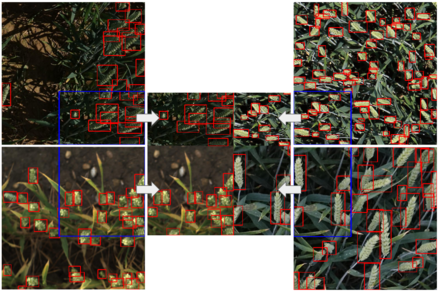


Here is a simple explanation using cat images: 



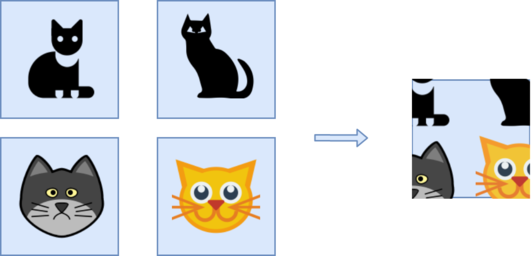

<a id="tta"></a>

## TTA


TTA, short for **test-time augmentation**, is a popular technique for getting better performance for computer vision tasks and you will often encounter it when doing Kaggle computer vision competitions.

How does it work?

The basic idea is quite simple: 

1. Create additional test images from the provided ones using **augmentation** techniques.
2. Predict using the trained model: you will have the prediction for the original image plus the augmented ones.
3. Blend the predictions: more on this in the next section 

For the augmentation step, horizantal and vertical flips are quite common strategies for TTA. Notice that since this step happens during inference time and since code competitions have time limits, you can't use a lot of augmentation. 
2 or 3 additional images per original test one is more than enough.
Finally, for object detection, since there is a bounding box to predict, the augmentation step should preserve the shape of the bounding box. Thus some augmentations aren't allowed (for instance 90 degrees rotations). 

To finish this section, here is an illustration (again, using cats :p)


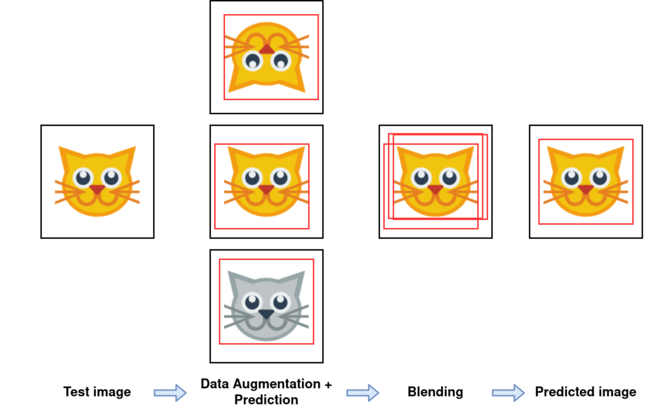

<a id="wbf"></a>

## WBF Blending


If you are accustomed to **object detection** tasks and challenges, you may have heard about **NMS** (short for non-maximum suppresion). Here is a short description of its pseudo-code:

<img src="https://miro.medium.com/max/840/1*CuqLjro26cHShpQVO1rgdQ.png" width=480>





Check this [post](https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c) for more details (the figure above is from it).


This technique is used to merge many boxes (called proposals) from one model and can be used to merge the results of many models as well. 

Here, we will go over another technique called **weighted-boxes fusion** or (**WBF** in short). 

To get started, you can check the Github implementation [here](https://github.com/ZFTurbo/Weighted-Boxes-Fusion), the [paper](https://arxiv.org/pdf/1910.13302.pdf) or this great [notebook](https://www.kaggle.com/shonenkov/wbf-approach-for-ensemble) again from [Alex Shonenkov](https://www.kaggle.com/shonenkov), so thanks!

So how does it work and how is it different? Let's have a look at the following schema (from the **WBF** paper)


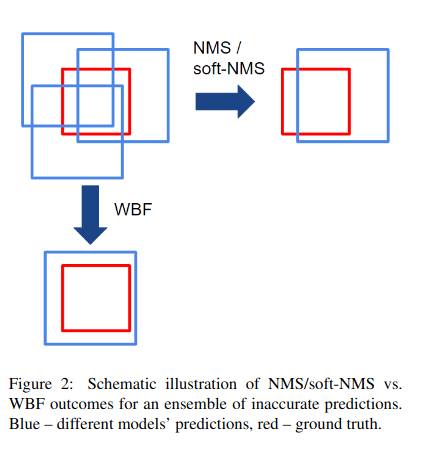


If you may have noticed, the **WBF** algorithm "made" a bounding box that isn't any of the proposed ones whereas NMS came up with one from the proposals. Indeed, that's one of the big differences between the two: how different proposals are merged. For the WBF case, the main objective is to compute a new confidence score C from existing confidence scores and then use it to compute the blended bounding box coordinates and confidence as a weighted mean (or other functions).


Finally, if you want even more blending techniques, you can explore these techniques:

- Soft-NMS: similar to NMS (non-maximum suppression) but with a soft selection criterion

<img src="https://miro.medium.com/max/794/1*G6-phMqZbwgozsFwe5FDUw.png" width=480>


- Non-maximum weighted (NMW): this is the same as the NMS but computing a weighted a bounding box instead
of computing only one.







<a id="wrap-up"></a>

# To Wrap Up

That's it for today. If you made it this far, congratulations!

By now, you should have acquired basic knowledge of **object detection** and **computer vision** more generally, you can 
now go and build models. Congratulations on gaining a new (super) power!

Stay tuned for the next notebook and in the meantime, happy kaggling!

<a id="go-beyond"></a>
## To Go Beyond

Going further, check these resources to expand your understanding: 
    
- Pytorch's torchvision object detection tutorialn very: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
- Learn more about efficientdet here: https://blog.roboflow.ai/breaking-down-efficientdet/
- If you want to learn more about computer vision using deep learning: A great playlist if you like videos: https://www.youtube.com/playlist?list=PL5-TkQAfAZFbzxjBHtzdVCWE0Zbhomg7r
- More specifically, this video is great for object detection: https://www.youtube.com/watch?v=TB-fdISzpHQ&list=PL5-TkQAfAZFbzxjBHtzdVCWE0Zbhomg7r&index=16&t=0s

- A good explanation of the differences between evaluation metrics: https://stats.stackexchange.com/questions/238684/what-are-the-difference-between-dice-jaccard-and-overlap-coefficients

- A complete explanation of EfficientDet: https://towardsdatascience.com/googles-efficientdet-an-overview-8d010fa15860
- Another EfficientDet Medium post: https://medium.com/@nainaakash012/efficientdet-scalable-and-efficient-object-detection-ea05ccd28427
- A paper comparing human-level performance vs some deep learning algorithms on vision tasks: https://arxiv.org/pdf/1706.06969.pdf
- Some augmentations notebook: https://www.kaggle.com/nvnnghia/awesome-augmentation
- Another EfficientDet Pytorch implementation: https://github.com/zylo117/Yet-Another-EfficientDet-Pytorch
- A very thorough series of object detection medium posts: https://medium.com/@jonathan_hui/object-detection-series-24d03a12f904